In [1]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os

import yaml
import torch
import torch.multiprocessing as mp

import utils
import trainers

from run_trainer import make_cfg


class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [3]:
args = AttrDict(
            {
                "cfg": "../cfgs/nvs_shapenet_cars_2shot.yaml",
                "load_root": "../data",
                "save_root": "save",
                "name": None,
                "tag": None,
                "cudnn": True,
                "wandb_upload": False,
                "port_offset": 0
            }
        )

cfg = make_cfg(args)
trainer = trainers.trainers_dict[cfg['trainer']](0, cfg)

[01-15 18:39:21] Environment setup done.


In [4]:
cfg["train_dataset"]["loader"]["batch_size"] = 2

Missing obj at ../data/learnit_shapenet/cars/302612708e86efea62d2c237bfbc22ca, skipped.
Missing obj at ../data/learnit_shapenet/cars/4ddef66f32e1902d3448fdcb67fe08ff, skipped.
Missing obj at ../data/learnit_shapenet/cars/e6c22be1a39c9b62fb403c87929e1167, skipped.
Missing obj at ../data/learnit_shapenet/cars/8070747805908ae62a9eb0f146e94477, skipped.
Missing obj at ../data/learnit_shapenet/cars/5bf2d7c2167755a72a9eb0f146e94477, skipped.
Missing obj at ../data/learnit_shapenet/cars/3c33f9f8edc558ce77aa0b62eed1492, skipped.
Missing obj at ../data/learnit_shapenet/cars/7aa9619e89baaec6d9b8dfa78596b717, skipped.
Missing obj at ../data/learnit_shapenet/cars/93ce8e230939dfc230714334794526d4, skipped.
Missing obj at ../data/learnit_shapenet/cars/d6ee8e0a0b392f98eb96598da750ef34, skipped.
Missing obj at ../data/learnit_shapenet/cars/986ed07c18a2e5592a9eb0f146e94477, skipped.
Missing obj at ../data/learnit_shapenet/cars/5973afc979049405f63ee8a34069b7c5, skipped.
Missing obj at ../data/learnit_sh

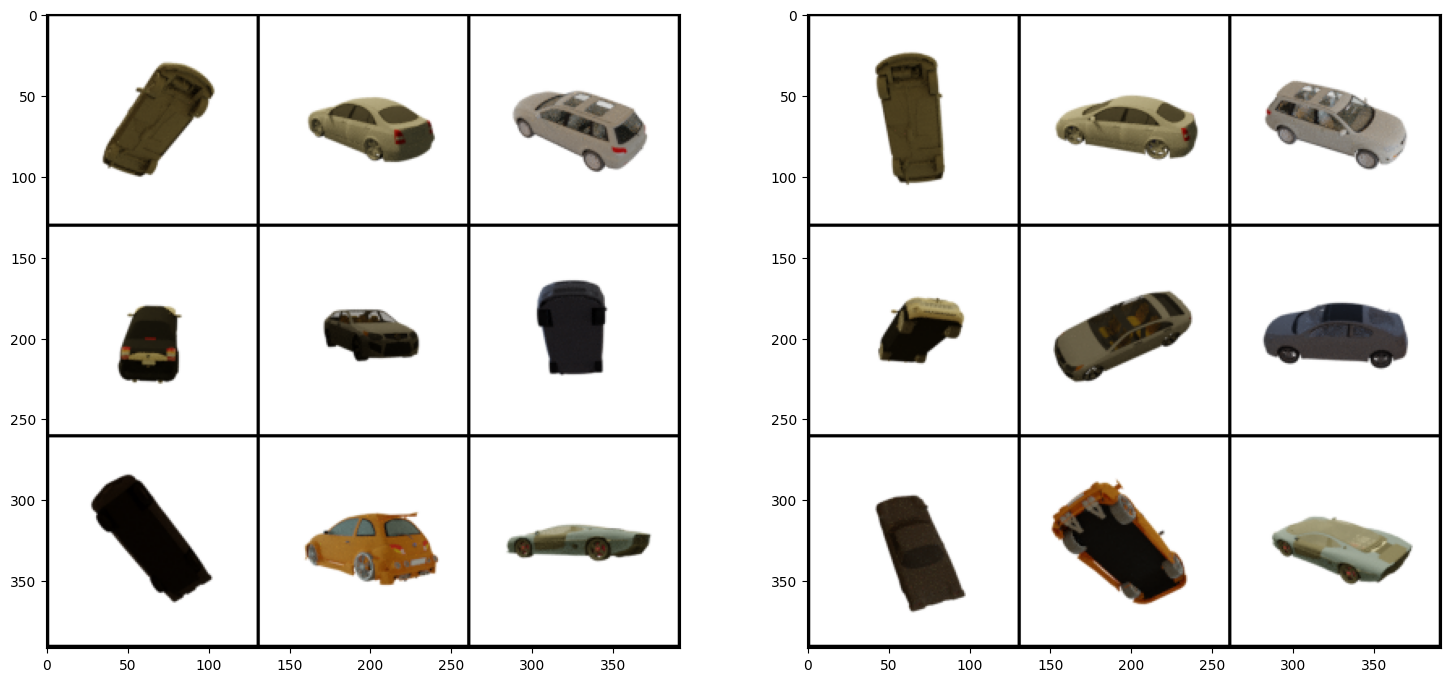

In [5]:
import numpy as np
import torchvision
import datasets
import matplotlib.pyplot as plt

train_dataset = datasets.make(cfg['train_dataset'])

sample_indices = np.random.choice(len(train_dataset), size=9, replace=False)
sample_inp = []
sample_gt = []
for i in sample_indices:
    inp, gt = train_dataset[i]["support_imgs"][0], train_dataset[i]["query_imgs"][0]
    sample_inp.append(inp)
    sample_gt.append(gt)
    
plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(sample_inp, nrow=3).permute(1, 2, 0).cpu().numpy())
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(sample_gt, nrow=3).permute(1, 2, 0).float().cpu().numpy())

In [6]:
trainer.make_datasets()

[01-15 18:39:27] Train dataset: len=3404
[01-15 18:39:27] Test dataset: len=100


Missing obj at ../data/learnit_shapenet/cars/302612708e86efea62d2c237bfbc22ca, skipped.
Missing obj at ../data/learnit_shapenet/cars/4ddef66f32e1902d3448fdcb67fe08ff, skipped.
Missing obj at ../data/learnit_shapenet/cars/e6c22be1a39c9b62fb403c87929e1167, skipped.
Missing obj at ../data/learnit_shapenet/cars/8070747805908ae62a9eb0f146e94477, skipped.
Missing obj at ../data/learnit_shapenet/cars/5bf2d7c2167755a72a9eb0f146e94477, skipped.
Missing obj at ../data/learnit_shapenet/cars/3c33f9f8edc558ce77aa0b62eed1492, skipped.
Missing obj at ../data/learnit_shapenet/cars/7aa9619e89baaec6d9b8dfa78596b717, skipped.
Missing obj at ../data/learnit_shapenet/cars/93ce8e230939dfc230714334794526d4, skipped.
Missing obj at ../data/learnit_shapenet/cars/d6ee8e0a0b392f98eb96598da750ef34, skipped.
Missing obj at ../data/learnit_shapenet/cars/986ed07c18a2e5592a9eb0f146e94477, skipped.
Missing obj at ../data/learnit_shapenet/cars/5973afc979049405f63ee8a34069b7c5, skipped.
Missing obj at ../data/learnit_sh

# Explore input data

In [7]:
train_dataset[0].keys()

dict_keys(['support_imgs', 'support_poses', 'support_focals', 'query_imgs', 'query_poses', 'query_focals', 'near', 'far'])

In [8]:
train_dataset[0]["support_imgs"].shape

torch.Size([2, 3, 128, 128])

In [9]:
train_dataset[0]["support_poses"][0]

tensor([[-0.9994, -0.0091,  0.0344,  0.1387],
        [ 0.0356, -0.2546,  0.9664,  3.8956],
        [ 0.0000,  0.9670,  0.2548,  1.0270]])

In [10]:
train_dataset[0]["support_focals"][0]

tensor([177.7778, 177.7778])

In [11]:
train_dataset[0]["query_imgs"].shape

torch.Size([1, 3, 128, 128])

In [12]:
train_dataset[0]["query_focals"][0]

tensor([177.7778, 177.7778])

# Setup model

In [14]:
trainer.make_model()
model = trainer.model
model_ddp = trainer.model_ddp

[01-15 18:39:46] Model: #params=44.5M


In [15]:
max_epoch = cfg['max_epoch']
eval_epoch = cfg.get('eval_epoch', max_epoch + 1)
vis_epoch = cfg.get('vis_epoch', max_epoch + 1)
save_epoch = cfg.get('save_epoch', max_epoch + 1)
epoch_timer = utils.EpochTimer(max_epoch)

max_epoch, eval_epoch, vis_epoch, save_epoch, epoch_timer

(1000, 10, 10, 1001, <utils.common.EpochTimer at 0x7fbb332b4b20>)

# Check model output

In [16]:
import utils

trainer.optimizer = utils.make_optimizer(trainer.model_ddp.parameters(), cfg['optimizer'])
trainer.epoch = 1

for data in trainer.train_loader:
    break

In [17]:
ret = trainer.train_step(data)

In [18]:
ret

{'loss': 0.1731591820716858}

# Detail walkthrough model pass

In [19]:
from utils.geometry import poses_to_rays, volume_rendering
import einops

In [20]:
data = {k: v.cuda() for k, v in data.items()}

In [21]:
query_imgs = data.pop('query_imgs')

In [22]:
query_imgs.shape

torch.Size([2, 1, 3, 128, 128])

In [23]:
hyponet = model_ddp(data)
hyponet

HypoNerf(
  (relu): ReLU()
)

In [24]:
B, _, _, H, W = query_imgs.shape

In [25]:
rays_o, rays_d = poses_to_rays(data['query_poses'], H, W, data['query_focals'])
gt = einops.rearrange(query_imgs, 'b n c h w -> b (n h w) c')
rays_o = einops.rearrange(rays_o, 'b n h w c -> b (n h w) c')
rays_d = einops.rearrange(rays_d, 'b n h w c -> b (n h w) c')

In [26]:
print(rays_o.shape, rays_d.shape, gt.shape)

torch.Size([2, 16384, 3]) torch.Size([2, 16384, 3]) torch.Size([2, 16384, 3])


In [27]:
n_sample = cfg['train_n_rays']
rays_o, rays_d, gt = trainer._adaptive_sample_rays(rays_o, rays_d, gt, n_sample)


In [28]:
print(rays_o.shape, rays_d.shape, gt.shape)

torch.Size([2, 128, 3]) torch.Size([2, 128, 3]) torch.Size([2, 128, 3])


In [29]:
pred = volume_rendering(
    hyponet, rays_o, rays_d,
    near=data['near'][0],
    far=data['far'][0],
    points_per_ray=cfg['train_points_per_ray'],
    use_viewdirs=hyponet.use_viewdirs,
    rand=True,
)

In [30]:
pred.shape

torch.Size([2, 128, 3])

# Debug novel view hypernet formation

In [31]:
hyponet = model_ddp.hyponet
tokenizer = model_ddp.tokenizer
transformer_encoder = model_ddp.transformer_encoder

### Debug tokenizer

In [32]:
dtokens = tokenizer(data)
print(dtokens.shape)

torch.Size([2, 512, 768])


In [33]:
imgs = data['support_imgs']
B = imgs.shape[0]
H, W = imgs.shape[-2:]

rays_o, rays_d = poses_to_rays(data['support_poses'], H, W, data['support_focals'])
rays_o = einops.rearrange(rays_o, 'b n h w c -> b n c h w')
rays_d = einops.rearrange(rays_d, 'b n h w c -> b n c h w')

print(imgs.shape, rays_o.shape)

torch.Size([2, 2, 3, 128, 128]) torch.Size([2, 2, 3, 128, 128])


In [34]:
import torch.nn.functional as F

x = torch.cat([imgs, rays_o, rays_d], dim=2)
print(x.shape)
x = einops.rearrange(x, 'b n d h w -> (b n) d h w')
print(x.shape)
p = tokenizer.patch_size
x = F.unfold(x, p, stride=p, padding=tokenizer.padding)
print(p, x.shape)
x = einops.rearrange(x, '(b n) ppd l -> b (n l) ppd', b=B)
print(x.shape)

torch.Size([2, 2, 9, 128, 128])
torch.Size([4, 9, 128, 128])
(8, 8) torch.Size([4, 576, 256])
torch.Size([2, 512, 576])


In [35]:
prefc = tokenizer.prefc
prefc
x = prefc(x)
print(x.shape)

torch.Size([2, 512, 768])


## Debug model pass through transformers

In [36]:
B = dtokens.shape[0]
wtokens = einops.repeat(model_ddp.wtokens, 'n d -> b n d', b=B)
print(model_ddp.wtokens.shape, wtokens.shape)

trans_out = transformer_encoder(torch.cat([dtokens, wtokens], dim=1))
trans_out = trans_out[:, -len(model_ddp.wtokens):, :]
print(trans_out.shape)

torch.Size([164, 768]) torch.Size([2, 164, 768])
torch.Size([2, 164, 768])


### Debug formation of init tokens

In [37]:
import torch.nn as nn

from models.trans_inr import init_wb

In [38]:
dim = 768
n_groups = 32
base_params = nn.ParameterDict()
n_wtokens = 0
wtoken_postfc = nn.ModuleDict()
wtoken_rng = dict()

In [39]:
print(hyponet.param_shapes.items())

dict_items([('wb0', (121, 256)), ('wb1', (257, 256)), ('wb2', (257, 256)), ('wb3', (257, 256)), ('wb4', (257, 256)), ('rgb_density_fc', (257, 4))])


In [40]:
for name, shape in hyponet.param_shapes.items():
    # initialise a weight matrix
    base_params[name] = nn.Parameter(init_wb(shape))
    print(base_params[name].shape)
    g = min(n_groups, shape[1])
    wtoken_postfc[name] = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, shape[0] - 1),
            )
    wtoken_rng[name] = (n_wtokens, n_wtokens + g)
    n_wtokens += g
    
wtokens = nn.Parameter(torch.randn(n_wtokens, dim))
print(wtokens.shape)

torch.Size([121, 256])
torch.Size([257, 256])
torch.Size([257, 256])
torch.Size([257, 256])
torch.Size([257, 256])
torch.Size([257, 4])
torch.Size([164, 768])


### Debug pass of data and init tokens through transformer

In [41]:
print(model_ddp.wtokens.shape)

torch.Size([164, 768])


In [42]:
B = dtokens.shape[0]
wtokens = einops.repeat(model_ddp.wtokens, 'n d -> b n d', b=B)
print(model_ddp.wtokens.shape, wtokens.shape)

torch.Size([164, 768]) torch.Size([2, 164, 768])


In [43]:
print(dtokens.shape, wtokens.shape)
trans_inp = torch.cat([dtokens, wtokens], dim=1)
print(trans_inp.shape)

torch.Size([2, 512, 768]) torch.Size([2, 164, 768])
torch.Size([2, 676, 768])


In [44]:
layers = transformer_encoder.layers

x = trans_inp
for norm_attn, norm_ff in layers:
    print(x.shape)
    x = x + norm_attn(x)
    x = x + norm_ff(x)

torch.Size([2, 676, 768])
torch.Size([2, 676, 768])
torch.Size([2, 676, 768])
torch.Size([2, 676, 768])
torch.Size([2, 676, 768])
torch.Size([2, 676, 768])


In [45]:
norm_attn

PreNorm(
  (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (fn): Attention(
    (to_q): Linear(in_features=768, out_features=768, bias=False)
    (to_kv): Linear(in_features=768, out_features=1536, bias=False)
    (to_out): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): Dropout(p=0.0, inplace=False)
    )
  )
)

# Debug generation of hypernetwork weights

In [46]:
params = dict()
print(trans_out.shape, n_wtokens)

torch.Size([2, 164, 768]) 164


In [52]:
model_ddp.wtoken_postfc

ModuleDict(
  (wb0): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=120, bias=True)
  )
  (wb1): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=256, bias=True)
  )
  (wb2): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=256, bias=True)
  )
  (wb3): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=256, bias=True)
  )
  (wb4): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=256, bias=True)
  )
  (rgb_density_fc): Sequential(
    (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=768, out_features=256, bias=True)
  )
)

In [69]:
print(hyponet.param_shapes.items())

dict_items([('wb0', (121, 256)), ('wb1', (257, 256)), ('wb2', (257, 256)), ('wb3', (257, 256)), ('wb4', (257, 256)), ('rgb_density_fc', (257, 4))])


In [58]:
wtoken_postfc = wtoken_postfc.cpu()
trans_out = trans_out.cpu()

In [79]:
params = dict()

for name, shape in hyponet.param_shapes.items():
    wb = einops.repeat(base_params[name], 'n m -> b n m', b=B)
    w, b = wb[:, :-1, :], wb[:, -1:, :]
    print(w.shape, b.shape)
    
    print("### Map the transformer output from 768 to lower dimension (row of the weight matrices)")
    # map the transformer output from 768 to 256
    l, r = wtoken_rng[name]
    x = wtoken_postfc[name](trans_out[:, l: r, :])
    print(wtoken_postfc[name])
    print(trans_out[:, l: r, :].shape)
    print(x.shape)
    
    print("### Transpose afet mappong to lower dim")
    x = x.transpose(-1, -2) # (B, shape[0] - 1, g)
    print(x.shape)
    print("### Repeating x to match dim with w and then dot product")
    print(w.shape)
    print(x.repeat(1, 1, w.shape[2] // x.shape[2]).shape)
    w = F.normalize(w * x.repeat(1, 1, w.shape[2] // x.shape[2]), dim=1)
    
    print("### Assign weigths to the hypernetwork weights")
    print(wb.shape)
    wb = torch.cat([w, b], dim=1)
    params[name] = wb
    break

torch.Size([2, 120, 256]) torch.Size([2, 1, 256])
### Map the transformer output from 768 to lower dimension (row of the weight matrices)
Sequential(
  (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=768, out_features=120, bias=True)
)
torch.Size([2, 32, 768])
torch.Size([2, 32, 120])
### Transpose afet mappong to lower dim
torch.Size([2, 120, 32])
### Repeating x to match dim with w and then dot product
torch.Size([2, 120, 256])
torch.Size([2, 120, 256])
### Assign weigths to the hypernetwork weights
torch.Size([2, 121, 256])
